In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Read in Data

In [209]:
from sklearn.model_selection import StratifiedShuffleSplit

# read in data 
data = pd.read_csv(r".\Data Carrard et al. 2022 MedTeach.csv")
    
data_info = pd.read_csv(r".\Codebook Carrard et al. 2022 MedTeach.csv", sep=";")
# print(data)
print(data_info.head(21).to_latex(index=False))

\begin{tabular}{lllrrr}
\toprule
Variable Name &                                     Variable Label &                                     Variable Scale &  Unnamed: 3 &  Unnamed: 4 &  Unnamed: 5 \\
\midrule
           id &                             Participants ID number &                                             string &         NaN &         NaN &         NaN \\
          age &                         age at questionnaire 20-21 &                                            numeric &         NaN &         NaN &         NaN \\
         year & CURICULUM YEAR : In which curriculum year are you? & 1=Bmed1; 2=Bmed2; 3=Bmed3; 4=Mmed1; 5=Mmed2; 6=... &         NaN &         NaN &         NaN \\
          sex & GENDER : To which gender do you identify the mo... &                       1=Man; 2=Woman; 3=Non-binary &         NaN &         NaN &         NaN \\
        glang &         MOTHER TONGUE: What is your mother tongue? & 1=French; 15=German; 20=English; 37=Arab; 51=Ba... &         NaN

C:\Users\orion\AppData\Local\Temp\ipykernel_17420\1183090734.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_info.head(21).to_latex(index=False))


### Visualize Burnout Metric Distribution

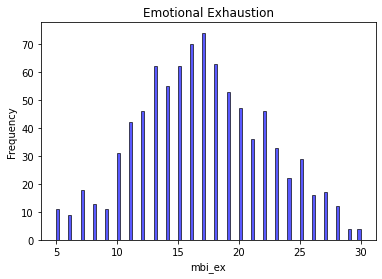

count    886.000000
mean      16.878104
std        5.256025
min        5.000000
25%       13.000000
50%       17.000000
75%       20.000000
max       30.000000
Name: mbi_ex, dtype: float64


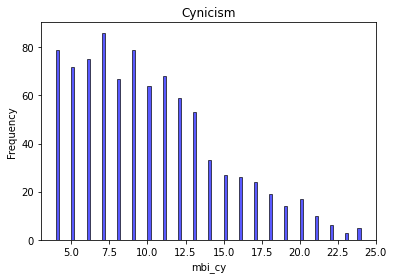

count    886.000000
mean      10.079007
std        4.592609
min        4.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       24.000000
Name: mbi_cy, dtype: float64


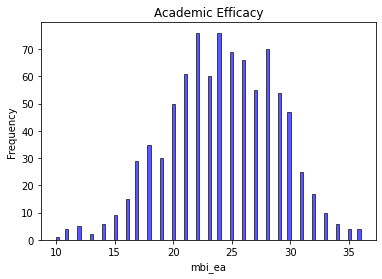

count    886.000000
mean      24.207675
std        4.633675
min       10.000000
25%       21.000000
50%       24.000000
75%       28.000000
max       36.000000
Name: mbi_ea, dtype: float64


In [210]:
#plot histogram of data, mbi_ex
plt.hist(data['mbi_ex'], bins=100, color='blue', edgecolor='black', alpha=0.65)
plt.xlabel('mbi_ex')
plt.ylabel('Frequency')
plt.title('Emotional Exhaustion')
plt.show()
print(data['mbi_ex'].describe())

plt.hist(data['mbi_cy'], bins=100, color='blue', edgecolor='black', alpha=0.65)
plt.xlabel('mbi_cy')
plt.ylabel('Frequency')
plt.title('Cynicism')
plt.show()
print(data['mbi_cy'].describe())

plt.hist(data['mbi_ea'], bins=100, color='blue', edgecolor='black', alpha=0.65)
plt.xlabel('mbi_ea')
plt.ylabel('Frequency')
plt.title('Academic Efficacy')
plt.show()
print(data['mbi_ea'].describe())



## Data Preprocessing

Here we set certain parameters to be more easily classified. 

In [211]:
#set 'sex' to 0 or 1
data['sex'] = data['sex'] - 1

#set 'mbi_ex' to 0 if below 24, 1 if above
data['mbi_ex'] = np.where(data['mbi_ex'] < 21.5, 0, 1)

#set 'mbi_cy' to 0 if below 10, 1 if above
data['mbi_cy'] = np.where(data['mbi_cy'] < 10, 0, 1)

#set 'mbi_ea' to 0 if above 31, 1 if below
data['mbi_ea'] = np.where(data['mbi_ea'] > 31, 0, 1)

#set 'glang' to 0 if not already 1
data['glang'] = np.where(data['glang'] > 1, 0, data['glang'])

#split half of the data randomly into training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(data, data["mbi_ex"]):
    train = data.loc[train_index]
    val = data.loc[val_index]


# Dataframe to hold results on performance of models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Metric Predicted'])

### Predicting Burnout:

It is important to note that these values for burnout were collected as a result of psychological surveys. If this were to be used in some automated fashion, then it would have to draw conclusions on data which would be accessable, but not in the form of a survey.

For the sake of this use case, its assumed that the following are known:

- age
- year
- sex
- mother tongue
- partnership status
- job status
- hours of study per week
- satisfaction with health
- was psychotherapy had in the last year

In [212]:
from sklearn import ensemble

y_ex_train = train['mbi_ex']
y_cy_train = train['mbi_cy']
y_ea_train = train['mbi_ea']
y_ex_val = val['mbi_ex']
y_cy_val = val['mbi_cy']
y_ea_val = val['mbi_ea']
val_X = val[['id', 'age', 'year', 'sex', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]
train_X = train[['id', 'age', 'year', 'sex', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]


## Fitting Random Forest
##### Using Random Forest to predict burnout values

In [215]:
#using random forest classifier to predict burnout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


n_estimators = [10, 100, 200, 1000]
max_depth = [2, 5, 20, 100, None]

# Exhaustion
max_performance = 0
best_forest_model = None
for n in n_estimators:
    for depth in max_depth:
        
        forest_model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=20)
        forest_model.fit(train_X, y_ex_train)

        performance = forest_model.score(val_X, y_ex_val)
        if performance > max_performance:
            best_n = n
            best_depth = depth
            max_performance = performance
            best_forest_model = forest_model

print("Forest Model - Classifier, Exhaustion")
print("Best n_estimators:", best_n)
print("Best max_depth:", best_depth)
print("Training score:", best_forest_model.score(train_X, y_ex_train))
print("Validation score:", best_forest_model.score(val_X, y_ex_val))

results = results.append({'Model': 'Forest Model - Classifier, Exhaustion', 'Accuracy': best_forest_model.score(val_X, y_ex_val), 'Metric Predicted': 'Exhaustion'}, ignore_index=True)

# Cynicism
print("Forest Model - Classifier, Cynicism")
forest_model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=20)
forest_model.fit(train_X, y_cy_train)
print("Training score:", forest_model.score(train_X, y_cy_train))
print("Validation score:", forest_model.score(val_X, y_cy_val))
results = results.append({'Model': 'Forest Model - Classifier, Cynicism', 'Accuracy': forest_model.score(val_X, y_cy_val), 'Metric Predicted': 'Cynicism'}, ignore_index=True)

# Academic Efficacy
print("Forest Model - Classifier, Academic Efficacy")
forest_model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=20)
forest_model.fit(train_X, y_ea_train)
print("Training score:", forest_model.score(train_X, y_ea_train))
print("Validation score:", forest_model.score(val_X, y_ea_val))
results = results.append({'Model': 'Forest Model - Classifier, Academic Efficacy', 'Accuracy': forest_model.score(val_X, y_ea_val), 'Metric Predicted': 'Academic Efficacy'}, ignore_index=True)


Forest Model - Classifier, Exhaustion
Best n_estimators: 10
Best max_depth: 2
Training score: 1.0
Validation score: 0.7584269662921348
Forest Model - Classifier, Cynicism


C:\Users\orion\AppData\Local\Temp\ipykernel_17420\1894273327.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'Forest Model - Classifier, Exhaustion', 'Accuracy': best_forest_model.score(val_X, y_ex_val), 'Metric Predicted': 'Exhaustion'}, ignore_index=True)


Training score: 1.0
Validation score: 0.5955056179775281
Forest Model - Classifier, Academic Efficacy


C:\Users\orion\AppData\Local\Temp\ipykernel_17420\1894273327.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'Forest Model - Classifier, Cynicism', 'Accuracy': forest_model.score(val_X, y_cy_val), 'Metric Predicted': 'Cynicism'}, ignore_index=True)


Training score: 1.0
Validation score: 0.9719101123595506


C:\Users\orion\AppData\Local\Temp\ipykernel_17420\1894273327.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'Forest Model - Classifier, Academic Efficacy', 'Accuracy': forest_model.score(val_X, y_ea_val), 'Metric Predicted': 'Academic Efficacy'}, ignore_index=True)


##### Evaluating Random Forest

## Fitting Neural Net
##### Using Neural Net to predict burnout values

In [214]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

# Exhaustion
print("Neural Network - Exhaustion")
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, y_ex_train, epochs=100, batch_size=10, verbose=0)
_, accuracy = model.evaluate(val_X, y_ex_val)
print('Accuracy: %.2f' % (accuracy*100))
results = results.append({'Model': 'Neural Network - Exhaustion', 'Accuracy': accuracy, 'Metric Predicted': 'Exhaustion'}, ignore_index=True)

# Cynicism
print("Neural Network - Cynicism")
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, y_cy_train, epochs=100, batch_size=10, verbose=0)
_, accuracy = model.evaluate(val_X, y_cy_val)
print('Accuracy: %.2f' % (accuracy*100))
results = results.append({'Model': 'Neural Network - Cynicism', 'Accuracy': accuracy, 'Metric Predicted': 'Cynicism'}, ignore_index=True)

# Academic Efficacy
print("Neural Network - Academic Efficacy")
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, y_ea_train, epochs=100, batch_size=10, verbose=0)
_, accuracy = model.evaluate(val_X, y_ea_val)
print('Accuracy: %.2f' % (accuracy*100))
results = results.append({'Model': 'Neural Network - Academic Efficacy', 'Accuracy': accuracy, 'Metric Predicted': 'Academic Efficacy'}, ignore_index=True)



Neural Network - Exhaustion
6/6 [==============================] - 0s 2ms/step - loss: 0.4829 - accuracy: 0.7865
Accuracy: 78.65
Neural Network - Cynicism


C:\Users\orion\AppData\Local\Temp\ipykernel_17420\2000117926.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'Neural Network - Exhaustion', 'Accuracy': accuracy, 'Metric Predicted': 'Exhaustion'}, ignore_index=True)


6/6 [==============================] - 0s 2ms/step - loss: 0.7712 - accuracy: 0.5618
Accuracy: 56.18
Neural Network - Academic Efficacy


C:\Users\orion\AppData\Local\Temp\ipykernel_17420\2000117926.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'Neural Network - Cynicism', 'Accuracy': accuracy, 'Metric Predicted': 'Cynicism'}, ignore_index=True)


KeyboardInterrupt: 

#### Evaluating Neural Net

## Evaluating Different Models
##### Breaking down and comparing different model performance, performance table shown.

In [ ]:
print(results)

                                          Model  Accuracy   Metric Predicted
0         Forest Model - Classifier, Exhaustion  0.758427         Exhaustion
1           Forest Model - Classifier, Cynicism  0.595506           Cynicism
2  Forest Model - Classifier, Academic Efficacy  0.971910  Academic Efficacy
3                   Neural Network - Exhaustion  0.786517         Exhaustion
4                     Neural Network - Cynicism  0.539326           Cynicism
5            Neural Network - Academic Efficacy  0.971910  Academic Efficacy
